# Sentiment Analysis of IMDB Movie Reviews

## Problem Statement:

* In this, we have to predict the number of positive and negative reviews based on sentiments by using different classification models.

* IMDB Dataset having 50K Movie Reviews for Text Analytics.

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from bs4 import BeautifulSoup
import spacy
import re,string,unicodedata
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from textblob import TextBlob
from textblob import Word
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import warnings
warnings.filterwarnings("ignore")

## Reading the Dataset

In [2]:
imdb_data = pd.read_csv("IMDB Dataset.csv")

In [3]:
imdb_data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [4]:
imdb_data.shape

(50000, 2)

## Exploratery Data Analysis

In [5]:
imdb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [6]:
imdb_data.describe().T

,count,unique,top,freq
review,50000,49582,Loved today's show!!! It was a variety and not...,5
sentiment,50000,2,negative,25000


In [7]:
imdb_data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

* We have balanced Data (50% Positive & 50% Negative)

* Dataset also don't have any missing values.

## Spliting Data into Train & Test

In [8]:
Train_reviews    = imdb_data.review[:40000]
Train_sentiments = imdb_data.sentiment[:40000]

Test_reviews     = imdb_data.review[40000:]
Test_sentiments  = imdb_data.sentiment[40000:]

In [9]:
print(" Train Dataset Shape : " ,Train_reviews.shape, Train_sentiments.shape)
print(" Test  Dataset Shape : " ,Test_reviews.shape, Test_sentiments.shape)

 Train Dataset Shape :  (40000,) (40000,)
 Test  Dataset Shape :  (10000,) (10000,)


## PreProcessing of Text

### Text Normalization
### Tokenization

In [10]:
tokenizer = ToktokTokenizer()

stopword_list = nltk.corpus.stopwords.words('english')

### Removing Html Strips & Noise Text

In [11]:
#Removing the html strips
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)


#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    return text

#Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(denoise_text)

### Removing Special Characters

In [12]:
def remove_special_characters(text, remove_digits = True):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern,'',text)
    return text


#Apply function on review column
imdb_data['review'] = imdb_data['review'].apply(remove_special_characters)

### Text Stemming

In [13]:
def simple_stemmer(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text


imdb_data['review'] = imdb_data['review'].apply(simple_stemmer)

### Removing Stopwords

In [14]:
stop = set(stopwords.words('english'))

def remove_stopwords(text, is_lower_case = False):
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopword_list]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopword_list]
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text


imdb_data['review'] = imdb_data['review'].apply(remove_stopwords)

### Normalized Train Reviews

In [15]:
norm_train_reviews = imdb_data.review[:40000]
norm_train_reviews[0]

'one review ha mention watch 1 Oz episod youll hook right thi exactli happen meth first thing struck Oz wa brutal unflinch scene violenc set right word GO trust thi show faint heart timid thi show pull punch regard drug sex violenc hardcor classic use wordit call OZ nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda Em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti wa surreal couldnt say wa readi watch develop tast Oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison exp

### Normalized Test Reviews

In [16]:
norm_test_reviews = imdb_data.review[40000:]
norm_test_reviews[45005]

'read review watch thi piec cinemat garbag took least 2 page find somebodi els didnt think thi appallingli unfunni montag wasnt acm humour 70 inde ani era thi isnt least funni set sketch comedi ive ever seen itll till come along half skit alreadi done infinit better act monti python woodi allen wa say nice piec anim last 90 second highlight thi film would still get close sum mindless drivelridden thi wast 75 minut semin comedi onli world semin realli doe mean semen scatolog humour onli world scat actual fece precursor joke onli mean thi handbook comedi tit bum odd beaver niceif pubesc boy least one hand free havent found playboy exist give break becaus wa earli 70 way sketch comedi go back least ten year prior onli way could even forgiv thi film even made wa gunpoint retro hardli sketch clown subtli pervert children may cut edg circl could actual funni come realli quit sad kept go throughout entir 75 minut sheer belief may save genuin funni skit end gave film 1 becaus wa lower scoreand

## Bags of Words Model

* It is used to convert text documents to numerical vectors or bag of words.

In [17]:
cv = CountVectorizer(min_df = 0, max_df = 1, binary = False, ngram_range = (1,3))

cv_train_reviews = cv.fit_transform(norm_train_reviews)

cv_test_reviews = cv.transform(norm_test_reviews)

print('Bags of Words Model_cv_train:', cv_train_reviews.shape)
print('Bags of Words Model_cv_test :', cv_test_reviews.shape)

Bags of Words Model_cv_train: (40000, 6209089)
Bags of Words Model_cv_test : (10000, 6209089)


## TF-IDF usage

* Countvectorizer gives equal weightage to all the words, i.e. a word is converted to a column.
* TF-IDF is different from countvectorizer.
* vocabulary_ just gives a dict of indexes of the words.

In [18]:
tv = TfidfVectorizer(min_df = 0, max_df = 1, use_idf = True, ngram_range = (1,3))

tv_train_reviews = tv.fit_transform(norm_train_reviews)

tv_test_reviews = tv.transform(norm_test_reviews)

print('Tfidf_train:',tv_train_reviews.shape)
print('Tfidf_test:',tv_test_reviews.shape)

Tfidf_train: (40000, 6209089)
Tfidf_test: (10000, 6209089)


## Labeling the Text

In [19]:
lb = LabelBinarizer()

sentiment_data = lb.fit_transform(imdb_data['sentiment'])
print(sentiment_data.shape)

(50000, 1)


## Spliting the Sentiment Data

In [20]:
train_sentiments = sentiment_data[:40000]
test_sentiments  = sentiment_data[40000:]

print(train_sentiments)
print(test_sentiments)

[[1]
 [1]
 [1]
 ...
 [1]
 [0]
 [0]]
[[0]
 [0]
 [0]
 ...
 [0]
 [0]
 [0]]


## Modelling

### 1. Logistic Regression

In [21]:
lr = LogisticRegression(penalty = 'l2', max_iter = 500, C = 1, random_state = 42)

#Fitting the model for Bag of words
lr_bow = lr.fit(cv_train_reviews, train_sentiments)
print(lr_bow)

#Fitting the model for tfidf features
lr_tfidf = lr.fit(tv_train_reviews, train_sentiments)
print(lr_tfidf)

LogisticRegression(C=1, max_iter=500, random_state=42)
LogisticRegression(C=1, max_iter=500, random_state=42)


## Model Performane on Test Dataset

In [22]:
#Predicting the model for bag of words
lr_bow_predict = lr.predict(cv_test_reviews)
print(lr_bow_predict)

#Predicting the model for tfidf features
lr_tfidf_predict = lr.predict(tv_test_reviews)
print(lr_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


## Accuracy 

In [23]:
lr_bow_score = accuracy_score(test_sentiments,lr_bow_predict)
print("Accuarcy Score for Bags of Words Model :", lr_bow_score)

#Accuracy score for tfidf features
lr_tfidf_score = accuracy_score(test_sentiments,lr_tfidf_predict)
print("Accuarcy Score for TF-IDF              :",lr_tfidf_score)

Accuarcy Score for Bags of Words Model : 0.7512
Accuarcy Score for TF-IDF              : 0.75


In [24]:
print("\n Classification report for Bags of Words Model features\n")
lr_bow_report = classification_report(test_sentiments, lr_bow_predict, target_names = ['Positive','Negative'])
print(lr_bow_report)

print("\n Classification report for TF_IDF features\n")
lr_tfidf_report = classification_report(test_sentiments, lr_tfidf_predict, target_names = ['Positive','Negative'])
print(lr_tfidf_report)


 Classification report for Bags of Words Model features

              precision    recall  f1-score   support

    Positive       0.75      0.75      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000


 Classification report for TF_IDF features

              precision    recall  f1-score   support

    Positive       0.74      0.77      0.75      4993
    Negative       0.76      0.73      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



## Confusion matrix

In [25]:
cm_bow = confusion_matrix(test_sentiments, lr_bow_predict, labels = [1,0])
cm_tfidf = confusion_matrix(test_sentiments, lr_tfidf_predict, labels = [1,0])

Text(0.5, 15.0, 'Predicted label')

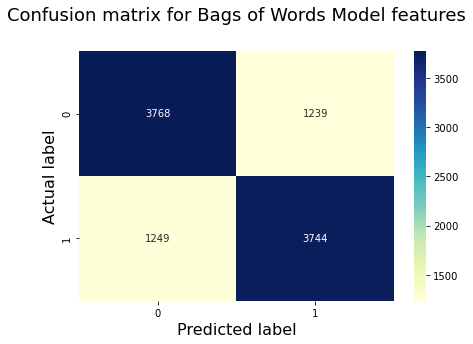

In [26]:
sns.heatmap(pd.DataFrame(cm_bow), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for Bags of Words Model features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

Text(0.5, 15.0, 'Predicted label')

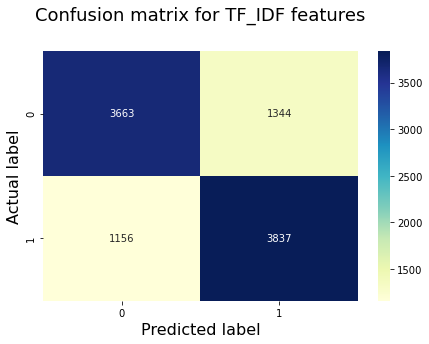

In [27]:
sns.heatmap(pd.DataFrame(cm_tfidf), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for TF_IDF features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

### 2. Stochastic Gradient Descent or Linear Support Vector Machines

In [28]:
#training the linear svm
svm = SGDClassifier(loss = 'hinge', max_iter = 500, random_state = 42)

#fitting the svm for bag of words
svm_bow = svm.fit(cv_train_reviews, train_sentiments)
print(svm_bow)

#fitting the svm for tfidf features
svm_tfidf = svm.fit(tv_train_reviews, train_sentiments)
print(svm_tfidf)

SGDClassifier(max_iter=500, random_state=42)
SGDClassifier(max_iter=500, random_state=42)


## Model Performane on Test Dataset

In [29]:
svm_bow_predict = svm.predict(cv_test_reviews)
print(svm_bow_predict)

svm_tfidf_predict = svm.predict(tv_test_reviews)
print(svm_tfidf_predict)

[1 1 0 ... 1 1 1]
[1 1 1 ... 1 1 1]


## Accuracy

In [30]:
svm_bow_score = accuracy_score(test_sentiments, svm_bow_predict)
print("svm_bow_score :" ,svm_bow_score)

svm_tfidf_score = accuracy_score(test_sentiments, svm_tfidf_predict)
print("svm_tfidf_score :" ,svm_tfidf_score)

svm_bow_score : 0.5829
svm_tfidf_score : 0.5112


In [31]:
print("\n Classification report for Bags of Words Model features\n")
svm_bow_report = classification_report(test_sentiments, svm_bow_predict, target_names = ['Positive','Negative'])
print(svm_bow_report)

print("\n Classification report for TF_IDF features\n")
svm_tfidf_report = classification_report(test_sentiments, svm_tfidf_predict, target_names = ['Positive','Negative'])
print(svm_tfidf_report)


 Classification report for Bags of Words Model features

              precision    recall  f1-score   support

    Positive       0.94      0.18      0.30      4993
    Negative       0.55      0.99      0.70      5007

    accuracy                           0.58     10000
   macro avg       0.74      0.58      0.50     10000
weighted avg       0.74      0.58      0.50     10000


 Classification report for TF_IDF features

              precision    recall  f1-score   support

    Positive       1.00      0.02      0.04      4993
    Negative       0.51      1.00      0.67      5007

    accuracy                           0.51     10000
   macro avg       0.75      0.51      0.36     10000
weighted avg       0.75      0.51      0.36     10000



In [32]:
cm_bow = confusion_matrix(test_sentiments, svm_bow_predict, labels = [1,0])
cm_tfidf = confusion_matrix(test_sentiments, svm_tfidf_predict, labels = [1,0])

Text(0.5, 15.0, 'Predicted label')

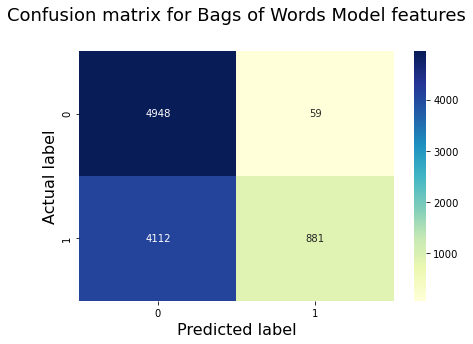

In [33]:
sns.heatmap(pd.DataFrame(cm_bow), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for Bags of Words Model features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

Text(0.5, 15.0, 'Predicted label')

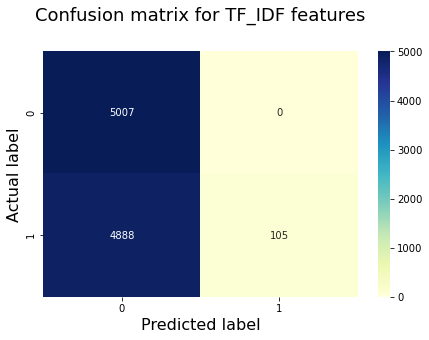

In [34]:
sns.heatmap(pd.DataFrame(cm_tfidf), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for TF_IDF features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

### 3. Naive Bayes

In [35]:
mnb = MultinomialNB()
mnb_bow = mnb.fit(cv_train_reviews, train_sentiments)
print(mnb_bow)

mnb_tfidf = mnb.fit(tv_train_reviews, train_sentiments)
print(mnb_tfidf)

MultinomialNB()
MultinomialNB()


## Model Performane on Test Dataset

In [36]:
mnb_bow_predict = mnb.predict(cv_test_reviews)
print(mnb_bow_predict)

mnb_tfidf_predict = mnb.predict(tv_test_reviews)
print(mnb_tfidf_predict)

[0 0 0 ... 0 1 1]
[0 0 0 ... 0 1 1]


## Accuracy 

In [37]:
mnb_bow_score = accuracy_score(test_sentiments, mnb_bow_predict)
print("mnb_bow_score :" ,mnb_bow_score)

mnb_tfidf_score = accuracy_score(test_sentiments, mnb_tfidf_predict)
print("mnb_tfidf_score :",mnb_tfidf_score)

mnb_bow_score : 0.751
mnb_tfidf_score : 0.7509


In [38]:
print("\n Classification report for Bags of Words Model features\n")
mnb_bow_report = classification_report(test_sentiments, mnb_bow_predict, target_names = ['Positive','Negative'])
print(mnb_bow_report)

print("\n Classification report for TF_IDF features\n")
mnb_tfidf_report = classification_report(test_sentiments, mnb_tfidf_predict, target_names = ['Positive','Negative'])
print(mnb_tfidf_report)


 Classification report for Bags of Words Model features

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.75      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000


 Classification report for TF_IDF features

              precision    recall  f1-score   support

    Positive       0.75      0.76      0.75      4993
    Negative       0.75      0.74      0.75      5007

    accuracy                           0.75     10000
   macro avg       0.75      0.75      0.75     10000
weighted avg       0.75      0.75      0.75     10000



In [39]:
cm_bow = confusion_matrix(test_sentiments, mnb_bow_predict, labels = [1,0])
cm_tfidf = confusion_matrix(test_sentiments, mnb_tfidf_predict, labels = [1,0])

Text(0.5, 15.0, 'Predicted label')

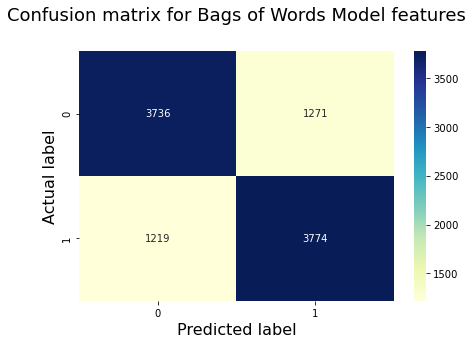

In [40]:
sns.heatmap(pd.DataFrame(cm_bow), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for Bags of Words Model features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

Text(0.5, 15.0, 'Predicted label')

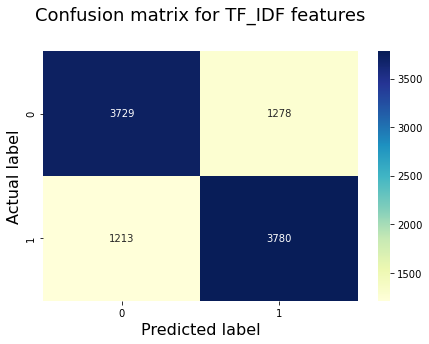

In [41]:
sns.heatmap(pd.DataFrame(cm_tfidf), annot = True, cmap = "YlGnBu" , fmt = 'g')
plt.tight_layout()
plt.title('Confusion matrix for TF_IDF features', y = 1.1, fontsize = 18)
plt.ylabel('Actual label', fontsize = 16)
plt.xlabel('Predicted label', fontsize = 16)

In [42]:
from sklearn.metrics import roc_curve
lr_bow_FPR,lr_bow_TPR,lr_bow_Thresholds = roc_curve(test_sentiments, lr_bow_predict)

fpr_series = pd.Series(lr_bow_FPR)
tpr_series = pd.Series(lr_bow_TPR)
thresholds_series = pd.Series(lr_bow_Thresholds)

df = pd.concat([fpr_series,tpr_series,thresholds_series], axis = 1, keys = ['FPR','TPR','THRESHOLD'])
df.sort_values(by = 'TPR', ascending = False)

,FPR,TPR,THRESHOLD
2,1.00000,1.000000,0
1,0.25015,0.752546,1
0,0.00000,0.000000,2


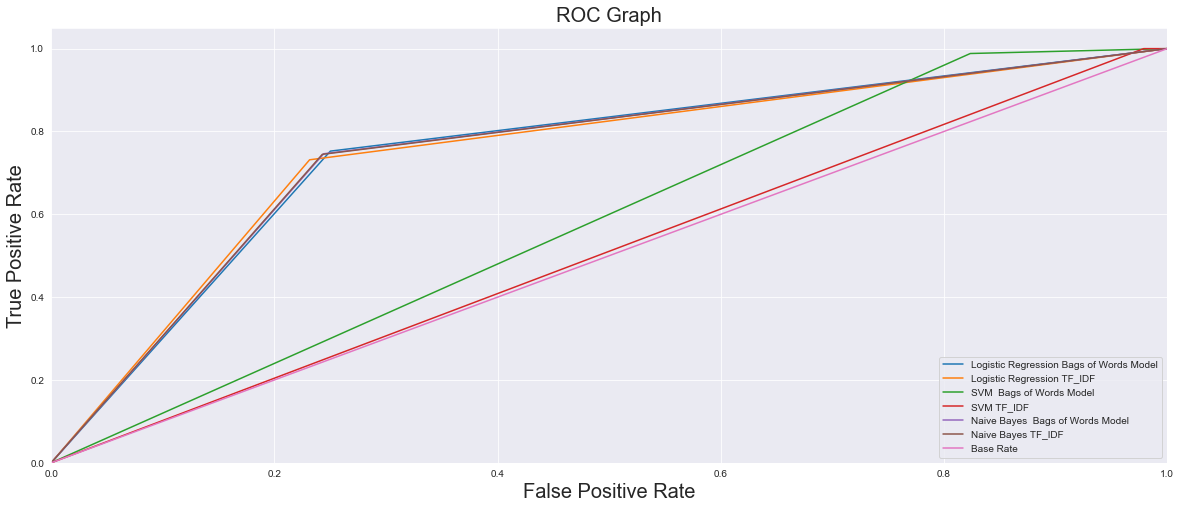

In [43]:
from sklearn.metrics import roc_curve

df = pd.concat([fpr_series,tpr_series,thresholds_series], axis = 1, keys = ['FPR','TPR','THRESHOLD'])
lr_bow_FPR,lr_bow_TPR,lr_bow_Thresholds = roc_curve(test_sentiments, lr_bow_predict)
lr_tfidf_FPR,lr_tfidf_TPR,lr_tfidf_Thresholds = roc_curve(test_sentiments, lr_tfidf_predict)

svm_bow_FPR,svm_bow_TPR,svm_bow_Thresholds = roc_curve(test_sentiments, svm_bow_predict)
svm_tfidf_FPR,svm_tfidf_TPR,svm_tfidf_Thresholds = roc_curve(test_sentiments, svm_tfidf_predict)

mnb_bow_FPR,mnb_bow_TPR,mnb_bowf_Thresholds = roc_curve(test_sentiments, mnb_bow_predict)
mnb_tfidf_FPR,mnb_tfidf_TPR,mnb_tfidf_Thresholds = roc_curve(test_sentiments, mnb_tfidf_predict)


sns.set_style("darkgrid")
plt.figure(figsize = (20,8))

# Plot Logistic Regression ROC
plt.plot(lr_bow_FPR,lr_bow_TPR, label ='Logistic Regression Bags of Words Model')
plt.plot(lr_tfidf_FPR,lr_tfidf_TPR, label ='Logistic Regression TF_IDF')

# Plot SVM ROC
plt.plot(svm_bow_FPR,svm_bow_TPR, label = 'SVM  Bags of Words Model' )
plt.plot(svm_tfidf_FPR,svm_tfidf_TPR, label = 'SVM TF_IDF' )

# Plot Naive Bayes ROC
plt.plot(mnb_bow_FPR,mnb_bow_TPR, label = 'Naive Bayes  Bags of Words Model' )
plt.plot(mnb_tfidf_FPR,mnb_tfidf_TPR, label = 'Naive Bayes TF_IDF')

# Plot Base Rate ROC
plt.plot([0,1], [0,1], label = 'Base Rate')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize = 20)
plt.ylabel('True Positive Rate', fontsize = 20)
plt.title('ROC Graph', fontsize = 20)
plt.legend(loc = "lower right")
plt.show()

## Word Cloud

<function matplotlib.pyplot.show(close=None, block=None)>

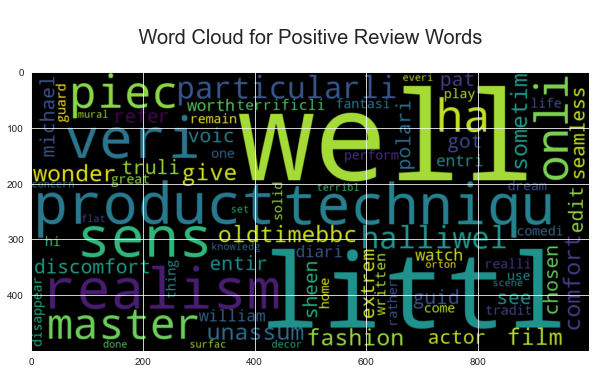

In [44]:
plt.figure(figsize = (10,10))
positive_text = norm_train_reviews[1]
WC = WordCloud(width = 1000, height = 500, max_words = 500, min_font_size = 5)
positive_words = WC.generate(positive_text)
plt.imshow(positive_words, interpolation = 'bilinear')
plt.title("\n Word Cloud for Positive Review Words \n", fontsize = 20)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

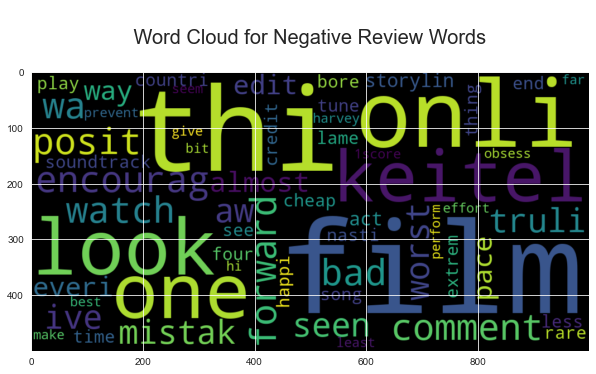

In [45]:
plt.figure(figsize = (10,10))
negative_text = norm_train_reviews[8]
WC = WordCloud(width = 1000, height = 500, max_words = 500, min_font_size = 5)
negative_words = WC.generate(negative_text)
plt.imshow(negative_words, interpolation = 'bilinear')
plt.title("\n Word Cloud for Negative Review Words \n", fontsize = 20)
plt.show

## Conclusion:

* We can Observed that Logistic Regression Model Performing well.


* Logistic Regression Accuarcy Score for Bags of Words Model = 75.12%
* Logistic Regression Accuarcy Score for TF-IDF = 75%


* Support Vector Machines (SVM) Accuarcy Score for Bags of Words Model = 58.29%
* Support Vector Machines (SVM) Accuarcy Score for TF-IDF = 51.12%


* Naive Bayes Accuarcy Score for Bags of Words Model = 75.1%
* Naive Bayes Accuarcy Score for TF-IDF = 75.09%